<img src="FIGURES/GIGGLES_FALL_2017.001.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.002.jpeg" />

# Python Data Processing 

In [1]:
# python modules 
import sys
import os 
import glob 
from datetime import datetime 

# array, numerical and plotting modules 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import pandas as pd 
import mpld3

# seismology module
import obspy 

# ipython 
from IPython.display import YouTubeVideo

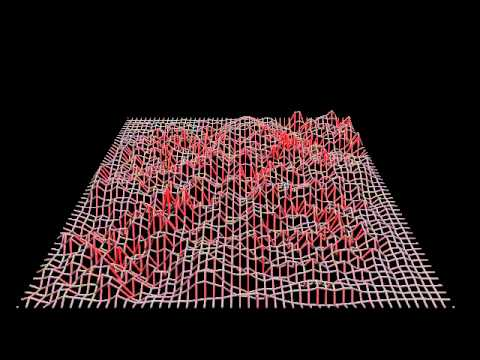

In [2]:
YouTubeVideo('4rYOF14Km9s')

# Ambient Noise Cross-Correlation 
- We want to find the Green's function $G_{AB}$, or impulse response, between seismometers $A$ and $B$.  

- The cross-correlation of a completely random wave-field $F(t)$ converges to the complete Green’s function $G(t)$ of the medium.

$$ \large \lim_{t\to\infty} \frac{\partial}{\partial t}C_{AB}(t) \approx F(t) * [G_{AB}(t) - G_{BA}(-t)] $$

where the cross-correlation $C_{AB}$ is defined

$$ \large C_{AB}(\tau )\ =\int _{-\infty }^{\infty }A^{*}(t)\ B(t+\tau )\, dt$$

In the frequency domain, this simplifies to 

$$  \large \mathcal{C}_{AB}(\omega) = A(\omega)^* \cdot B(\omega)$$

- This means all we only need to cross-correlate data at two stations to recover the Green's function between them. 

# (Hydro)Seismology Data Processing 
## Load Raw Data using Obspy

In [3]:
# load raw data using Obspy
RIO = "/Users/thclements/Desktop/GIGGLES_DATA/RIO"
RIO_mseed = os.path.join(RIO,"*.mseed")
RUS = "/Users/thclements/Desktop/GIGGLES_DATA/RUS"
RUS_mseed = os.path.join(RUS,"*.mseed")

st1 = obspy.read(RIO_mseed)
st2 = obspy.read(RUS_mseed)

## Plot Waveforms 

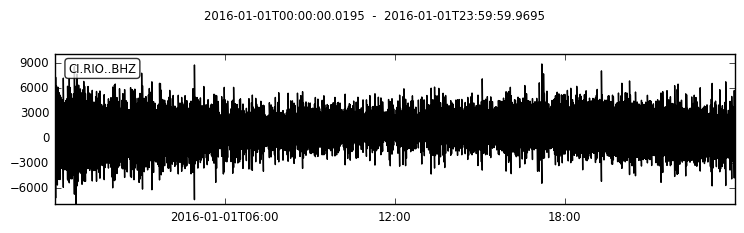

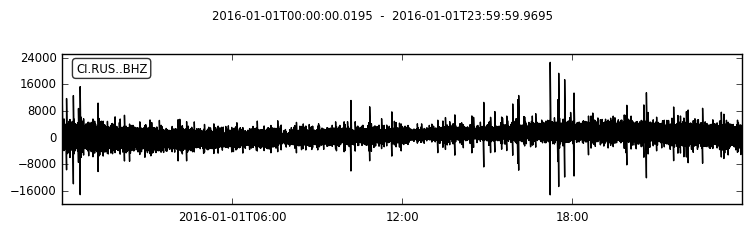

In [4]:
# plot waveforms 
tr1 = st1[0].interpolate(20.)
tr2 = st2[0].interpolate(20.)
t1,t2 = tr1.stats.starttime,tr1.stats.endtime
t3,t4 = tr2.stats.starttime,tr2.stats.endtime
t1,t2 = np.max([t1,t3]),np.min([t2,t4])
tr1,tr2 = tr1.slice(t1,t2),tr2.slice(t1,t2)
tr1.plot()
tr2.plot()

## Plot Spectrogram 

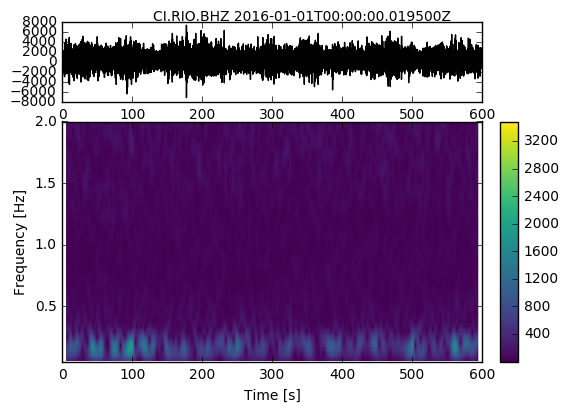

In [5]:
sys.path.append('/Users/thclements/odyssey')
from tools import spect
spect(tr1.copy().slice(t1,t1+600),fmin = 0.05,fmax=2.)

## Preprocessing 
- Before we can cross-correlate, we need to clean up our data:
        - Remove the mean of each waveform (demean)
        - Remove any linear trends in the waveform (detrend)
        - Taper the waveform to zero at either end 
        - Bandpass filter the waveform to remove low and high frequency components 

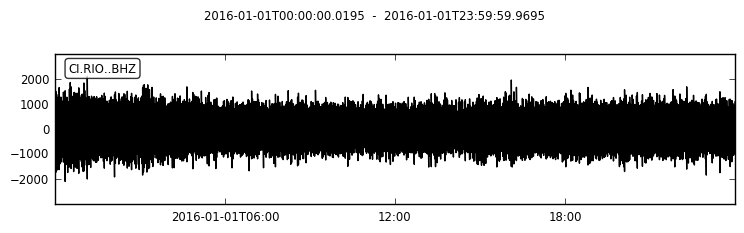

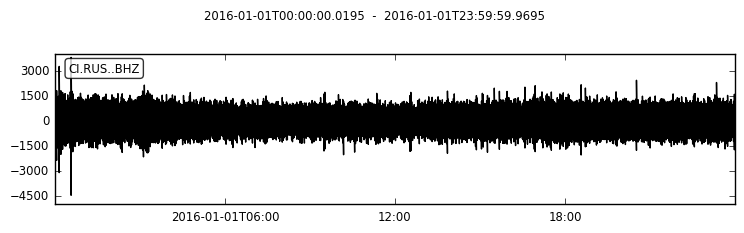

In [6]:
from obspy.signal.filter import bandpass
def clean_up(data,sampling_rate,freqmin,freqmax):
    if data.ndim == 2:
        axis = 1
    else:
        axis = 0
    data = scipy.signal.detrend(data,axis=axis,type='constant')
    data = scipy.signal.detrend(data,axis=axis,type='linear')
    percent = sampling_rate * 20 / data.shape[axis]
    taper = scipy.signal.tukey(data.shape[axis],percent)
    data *= taper
    data = bandpass(data,freqmin,freqmax,sampling_rate,zerophase=True)
    return data

freqmin,freqmax = 0.05,4.0
tr1.data = clean_up(tr1.data,tr1.stats.sampling_rate,freqmin,freqmax)
tr2.data = clean_up(tr2.data,tr2.stats.sampling_rate,freqmin,freqmax)
tr1.plot()
tr2.plot()

## Frequency Domain Whitening 
- The theory above applies for a single frequency $\omega$ and assumes that all frequencies have equal power.
- The noise spectrum in the Earth is not white (Shearer, 2009). 
<img src="FIGURES/Shearer_2009.jpg">

- We also have to worry about seasonality in the ambient noise (Zhan et al., 2013). 

<img src="FIGURES/seasonal.png" height="30px">

### Complex Number Aside 
The outputs of an $\texttt{fft}$ are complex. Recall that a complex number $z$ can be expressed as

$$ \large z = r(\cos \phi + i \sin \phi) = r e^{i \phi}$$

<img src="FIGURES/complex.png" >

So to "whiten" the frequency spectrum, we can just set $r = 1$ in a certain frequency band of our $\texttt{fft}$.
### Transform to Frequency Domain 

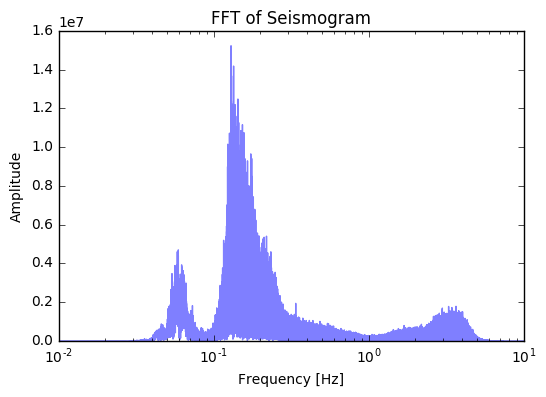

In [7]:
from scipy.fftpack.helper import next_fast_len
Nfft = next_fast_len(int(tr1.data.shape[0]))
fft1 = scipy.fftpack.fft(tr1.data,Nfft)
freqs = scipy.fftpack.fftfreq(Nfft, d=tr1.stats.delta)[:Nfft // 2]
ind = np.where(freqs > 0.01)[0]

# plot frequency data 
plt.semilogx(freqs[ind],np.abs(fft1[:Nfft//2][ind]),'b-',alpha =0.5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('FFT of Seismogram')
plt.show()

### Whitening 

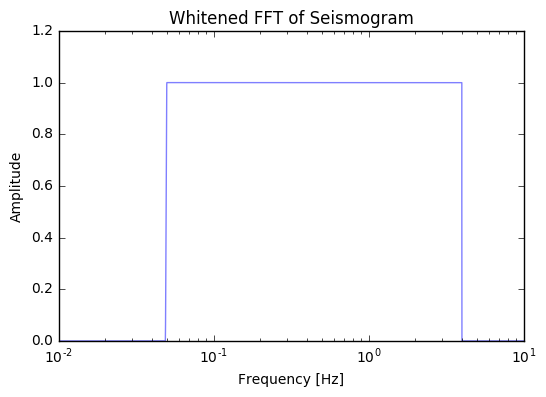

In [8]:
from compute_cc import whiten 
white1 = whiten(tr1.copy().data,tr1.stats.delta,freqmin,freqmax,Nfft)
white2 = whiten(tr2.copy().data,tr1.stats.delta,freqmin,freqmax,Nfft)
plt.semilogx(freqs[ind],np.abs(white1[:Nfft//2][ind]),'b-',alpha =0.5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Whitened FFT of Seismogram')
plt.show()

### Transform Back to Time Domain 

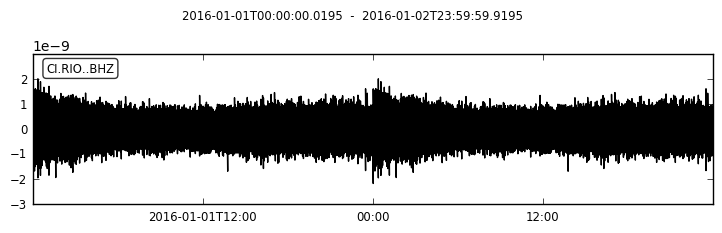

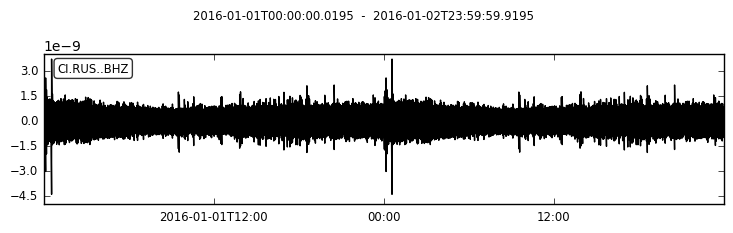

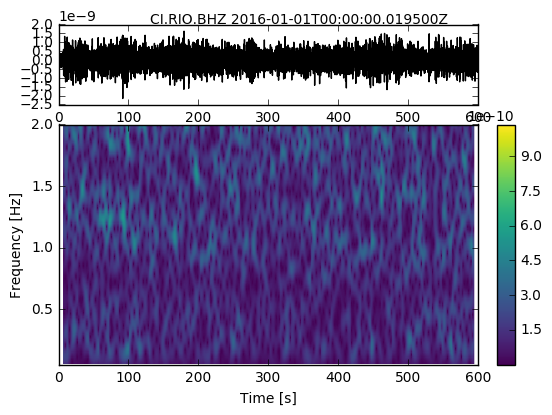

In [9]:
# take inverse fft 
twhite1 = np.real(scipy.fftpack.ifft(white1, Nfft)) / Nfft
twhite2 = np.real(scipy.fftpack.ifft(white2, Nfft)) / Nfft
twhite1 = np.concatenate((twhite1[-Nfft + 1:], twhite1[:Nfft + 1]))
twhite2 = np.concatenate((twhite2[-Nfft + 1:], twhite2[:Nfft + 1]))

# update data and plot
tr1.data,tr2.data = twhite1,twhite2
tr1.plot()
tr2.plot()
spect(tr1.copy().slice(t1,t1+600),fmin = 0.05,fmax=2.)

## One-bit Normalization 